In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("database.csv")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [5]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [6]:
import pandas as pd

# Assuming data is your DataFrame
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

# Drop rows with NaT (Not a Timestamp) values
data = data.dropna(subset=['Datetime'])

# Extract timestamp and create 'Timestamp' column (astype('int64'))
data['Timestamp'] = (data['Datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Drop 'Date', 'Time', and 'Datetime' columns
final_data = data.drop(['Date', 'Time', 'Datetime'], axis=1)

final_data.head()


,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157630542
1,1.863,127.352,80.0,5.8,-157465811
2,-20.579,-173.972,20.0,6.2,-157355642
3,-59.076,-23.557,15.0,5.8,-157093817
4,11.938,126.427,15.0,5.8,-157026430


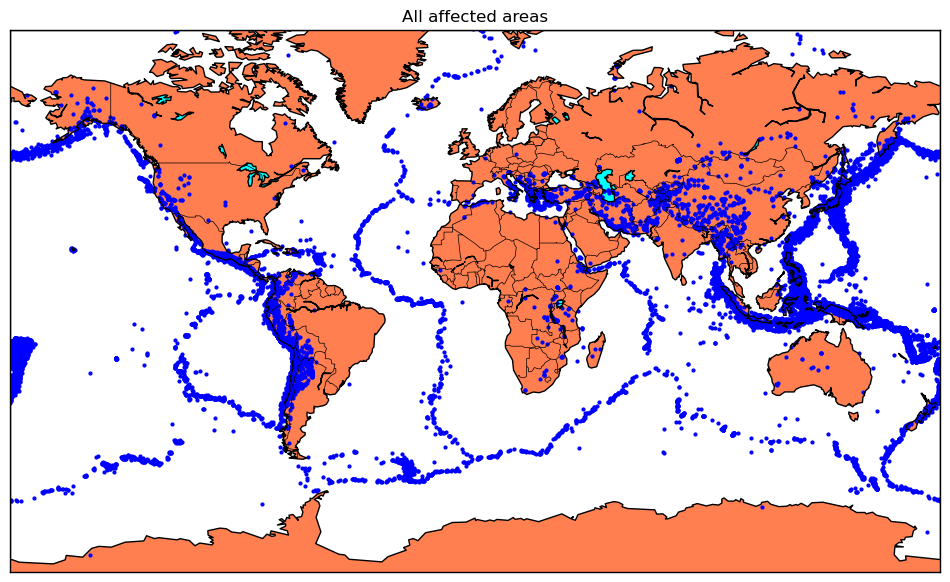

In [7]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()


In [8]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(18727, 3) (4682, 3) (18727, 2) (4682, 3)


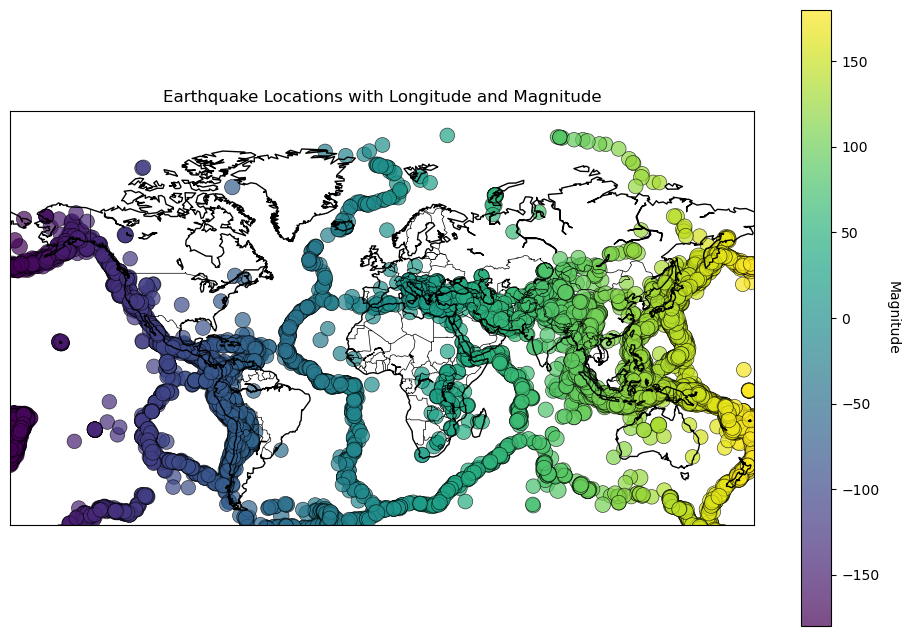

<Figure size 1200x800 with 0 Axes>

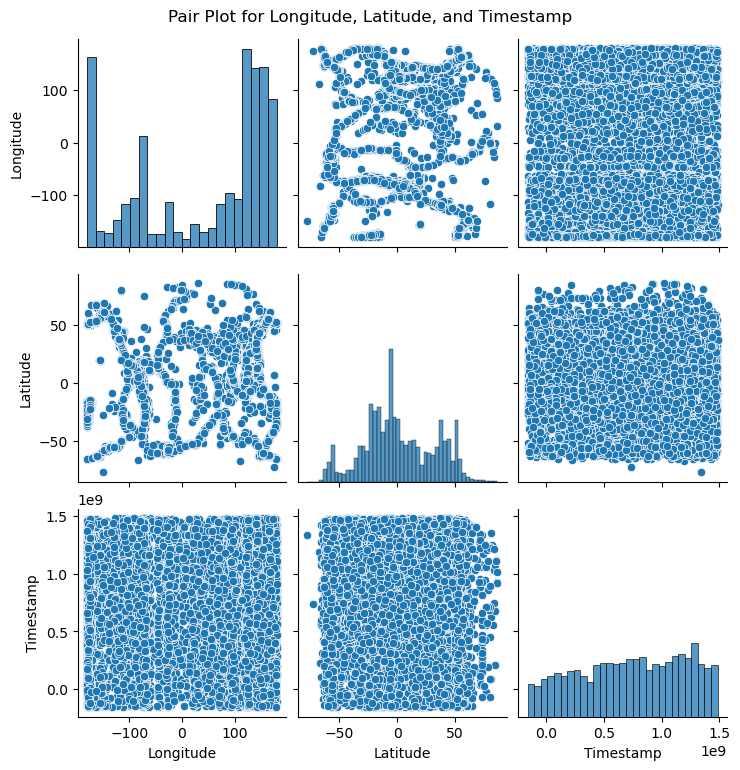

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Scatter plot for Longitude and Latitude with color representing Longitude and size representing Magnitude
plt.figure(figsize=(12, 8))

# Create a Basemap instance
m = Basemap(
    projection='mill',  # Miller Cylindrical projection
    llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180,  # Set the map boundaries
    resolution='c'  # Set the resolution
)

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert longitude and latitude to x and y coordinates in the map
x, y = m(X_train['Longitude'].values, X_train['Latitude'].values)

# Scatter plot with color representing Longitude and size representing Magnitude
scatter_plot = m.scatter(
    x, y,
    c=X_train['Longitude'],
    s=y_train['Magnitude'] * 20,  # Adjust the scaling factor for size
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',  # Add black borders to the markers for better visibility
    linewidths=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter_plot, label='Magnitude')
cbar.set_label('Magnitude', rotation=270, labelpad=15)

plt.title('Earthquake Locations with Longitude and Magnitude')
plt.show()

# Pair plot for Longitude, Latitude, and Timestamp
pair_plot_data = X_train.copy()
pair_plot_data['Timestamp'] = X_train['Timestamp']  # Add timestamp to the pair plot data

plt.figure(figsize=(12, 8))
pair_plot = sns.pairplot(pair_plot_data[['Longitude', 'Latitude', 'Timestamp']])
pair_plot.fig.suptitle('Pair Plot for Longitude, Latitude, and Timestamp', y=1.02)
plt.show()



In [11]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

C:\Users\Vashi\AppData\Local\Temp\ipykernel_10808\372383517.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [13]:
from sklearn.model_selection import GridSearchCV

# Your code for using GridSearchCV goes here


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.586970 using {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.000000 (0.000000) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.586702 (0.479655) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.586970 (0.455711) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.200000 (0.400000) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


In [14]:
model = Sequential()
model.add(Dense(16, activation='sigmoid', input_shape=(3,)))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
1873/1873 [==============================] - 7s 3ms/step - loss: 0.0039 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 2/20
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0039 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 3/20
1873/1873 [==============================] - 5s 3ms/step - loss: 0.0039 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 4/20
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 5/20
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 6/20
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: 0.9242
Epoch 7/20
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9182 - val_loss: 0.0039 - val_accuracy: